# Analysing and Predicting the Women's World Cup

<ul>
<li><a href="#motivation">Motivation</a></li>
    <ul>
    <li><a href="#requirements">Requirements</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#modeling">Modeling</a></li>
    <ul>
    <li><a href="#prep">Data Preparation</a></li>
    <li><a href="#preprocess">Preprocessing</a></li>
    <li><a href="#model_selection">Model Comparison</a></li>
    <li><a href="#best_model">Find the Best Model</a></li>
    </ul>
<li><a href="#final">Predictions</a></li>
</ul>

<a id='motivation'></a>
## Motivation

The FIFA Women's World Cup is in its eighth edition in 2019. It occurs every four years between June and July, and has teams from all continents. This edition is being held in France, and 24 teams qualified for the final tournament ([Wikipedia](https://en.wikipedia.org/wiki/2019_FIFA_Women%27s_World_Cup)).

Besides the similarities, the women's football is not even close to have the same visibility as the men's one (at least not in Brazil, but we imagine that it's the same in the whole world), and founding the data about previous matches wasn't very easy. There wasn't data available on FIFA's website or in any other "official" provider, but we found it on [Kaggle](https://www.kaggle.com/alexkaechele/womens-world-cup) (thanks a lot for inputing this data by hand).

This analysis and modeling has the intent of predicting the winners from the round of 16 to the final match. The data and code used is provided on our Github.

We are very excited to know who is going to win, and we hope you enjoy the results as much as we did working on it.

<a id='requirements'></a>
### Requirements

**python 3.7.1**

* bokeh==1.2.0
* ipython==7.4.0
* matplotlib==3.0.3
* numpy==1.16.2
* pandas==0.24.2
* scikit-learn==0.21.1
* scipy==1.2.1
* seaborn==0.9.0




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from IPython.core.display import display, HTML

import plots as ps

import warnings
warnings.filterwarnings('ignore')

output_notebook()

sns.set()
sns.set_palette("GnBu_d", 6)
%matplotlib inline

def create_link(id):
    display(HTML(f'<a id={id}></a>'))

Loading BokehJS ...

---
Loading data

In [2]:
scores_raw = pd.read_csv('womens_world_cup_data.csv')
ranking = pd.read_csv('womens_world_cup_rankings.csv')

<a id='wrangling'></a>
## Data Wrangling

In [3]:
scores_raw = pd.read_csv('womens_world_cup_data.csv')
ranking = pd.read_csv('womens_world_cup_rankings.csv')

display(scores_raw.shape)
display(ranking.shape)

(354, 7)

(150, 3)

In [4]:
scores_raw.head(3)

,Team_i,Team_j,home_i,home_j,score_i,score_j,year
0,china,thailand,0,0,4,0,2018
1,jordan,philippines,1,0,1,2,2018
2,philippines,china,0,0,0,3,2018


In [5]:
ranking.head(3)

,rank,team,rating
0,1,United States,2101
1,2,Germany,2072
2,3,England,2049


The countries names in `ranking` data have upper case letters, we are going to make it consistent with the `scores` data by changing them to lower case.

In [6]:
ranking.team = ranking.team.apply(lambda x: x.lower())
ranking.head(3)

,rank,team,rating
0,1,united states,2101
1,2,germany,2072
2,3,england,2049


#### Merging the DataFrames

In order to make easier to analyse the data, we are going to merge the DFs.

In [7]:
all_matches_i_j = (scores_raw.merge(ranking, left_on='Team_i', right_on='team')
                             .rename(columns={'Team_i': 'team_i',
                                              'rating': 'rating_i',
                                              'rank': 'rank_i'})
                             .drop(columns=['team'])
                             .merge(ranking, left_on='Team_j', right_on='team')
                             .rename(columns={'Team_j': 'team_j',
                                              'rating': 'rating_j',
                                              'rank': 'rank_j'})
                             .drop(columns=['team']))


all_matches = all_matches_i_j.rename(columns={'team_i': 'team_a',
                                              'home_i': 'home_a',
                                              'score_i': 'score_a',
                                              'rank_i': 'rank_a',
                                              'rating_i': 'rating_a',
                                              'team_j': 'team_b',
                                              'home_j': 'home_b',
                                              'score_j': 'score_b',
                                              'rank_j': 'rank_b',
                                              'rating_j': 'rating_b',})

display(all_matches.head())
display(all_matches.shape)

,team_a,team_b,home_a,home_b,score_a,score_b,year,rank_a,rating_a,rank_b,rating_b
0,china,thailand,0,0,4,0,2018,16,1866,34,1658
1,china,thailand,0,0,3,1,2018,16,1866,34,1658
2,australia,thailand,0,0,2,2,2018,6,2003,34,1658
3,united states,thailand,0,0,13,0,2019,1,2101,34,1658
4,sweden,thailand,0,0,5,1,2019,9,1962,34,1658


(354, 11)

<a id='eda'></a>
## Exploratory Data Analysis

Here are some questions we are going to address in this section:

[1. *Is a team more likely to win when playing at home?*](#question_1)

[2. *How many matches happened per year?*](#question_2)

[3. *Which are the top 10 teams with the most winnings?*](#question_3)

[4. *Which are the top 10 teams with the most loss?*](#question_4)

[5. *Are higher ratings related to more wins?*](#question_5)

In [8]:
# just keeping the merged data unalterated
eda_matches = all_matches.copy()

In [9]:
eda_matches['winner'] = 'draw'
eda_matches.loc[eda_matches.score_a > eda_matches.score_b, ['winner']] = 'win_a'
eda_matches.loc[eda_matches.score_a < eda_matches.score_b, ['winner']] = 'win_b'
eda_matches.sample(2, random_state=43)

,team_a,team_b,home_a,home_b,score_a,score_b,year,rank_a,rating_a,rank_b,rating_b,winner
93,australia,zimbabwe,0,0,6,1,2016,6,2003,102,1192,win_a
178,costa rica,canada,0,0,1,3,2018,36,1630,5,2006,win_b


---
Let's check how many draws and winnings we have in our data

In [10]:
winners = eda_matches.groupby('winner').count()[['team_a']]

In [11]:
ps.print_bar_chart(winners.index.values, winners.team_a, 'Results')

<a id='question_1'></a>
### 1. Is a team more likely to win when playing at home?

In [12]:
matches_a = eda_matches[['team_a', 'home_a', 'winner']].rename(columns={'team_a': 'team', 'home_a': 'home'})
matches_b = eda_matches[['team_b', 'home_b', 'winner']].rename(columns={'team_b': 'team', 'home_b': 'home'})

matches_a['team'] = 'team_a'
matches_b['team'] = 'team_b'

eda_all_matches = pd.concat([matches_a, matches_b], sort=False)
eda_all_matches.head()

,team,home,winner
0,team_a,0,win_a
1,team_a,0,win_a
2,team_a,0,draw
3,team_a,0,win_a
4,team_a,0,win_a


In [13]:
# number of matches at home
at_home = eda_all_matches[eda_all_matches['home'] == 1]

# number of matches out of home
not_home = eda_all_matches[eda_all_matches['home'] == 0]

# proportion of matches at home
p_home = at_home.shape[0] / eda_all_matches.shape[0]

# proportion of matches out of home
p_not_home = not_home.shape[0] / eda_all_matches.shape[0]

print(f'Proportion of matches at home: {p_home}')
print(f'Proportion of matches not at home: {p_not_home}')

Proportion of matches at home: 0.2740112994350282
Proportion of matches not at home: 0.7259887005649718


In [14]:
# proportion of teams that won at home
won_home = (at_home.query('team == "team_a" and winner == "win_a"').shape[0] +
            at_home.query('team == "team_b" and winner == "win_b"').shape[0])
p_win_home = won_home / at_home.shape[0]
print(f'Proportion of teams that won at home: {p_win_home}')

# proportion of teams that lost at home
lost_home = (at_home.query('team == "team_a" and winner == "win_b"').shape[0] +
             at_home.query('team == "team_b" and winner == "win_a"').shape[0])
p_lose_home = lost_home / at_home.shape[0]
print(f'Proportion of teams that lost at home: {p_lose_home}')

# proportion of teams that draw at home
p_draw_home = at_home.query('winner == "draw"').shape[0] / at_home.shape[0]
print(f'Proportion of teams that draw at home: {p_draw_home}')

# proportion of teams that won out of home
won_out_home = (not_home.query('team == "team_a" and winner == "win_a"').shape[0] +
                not_home.query('team == "team_b" and winner == "win_b"').shape[0])
p_win_out_home = won_out_home / not_home.shape[0]
print(f'Proportion of teams that won out of home: {p_win_out_home}')

# proportion of teams that lost out of home
lost_out_home = (not_home.query('team == "team_a" and winner == "win_b"').shape[0] +
                 not_home.query('team == "team_b" and winner == "win_a"').shape[0])
p_lose_out_home = lost_out_home / not_home.shape[0]
print(f'Proportion of teams that lost out of home: {p_lose_out_home}')

# proportion of teams that draw out of home
p_draw_out_home = not_home.query('winner == "draw"').shape[0] / not_home.shape[0]
print(f'Proportion of teams that draw out of home: {p_draw_out_home}')

Proportion of teams that won at home: 0.4742268041237113
Proportion of teams that lost at home: 0.38144329896907214
Proportion of teams that draw at home: 0.14432989690721648
Proportion of teams that won out of home: 0.4085603112840467
Proportion of teams that lost out of home: 0.44357976653696496
Proportion of teams that draw out of home: 0.14785992217898833


In order to answer if a team is more likely to win if it's playing at home, we need to know the probability of winning, as follow below...

In [15]:
# probability of winning
p_win = (p_home * p_win_home) + (p_not_home * p_win_out_home)
print(f'Probability of winning: {p_win}')

Probability of winning: 0.42655367231638414


**As we can see the probability of winning is 42.6%, while the probability of winning if playing at home is 47.4%.**

<a id='question_2'></a>
### 2. How many matches happened per year?

In [16]:
matches_per_year = eda_matches.groupby('year').count()[['team_a']]
ps.print_bar_chart(matches_per_year.index.values.astype(str), matches_per_year.team_a, 'Matches per Year')

<a id='question_3'></a>
### 3. Which are the top 10 teams with the most winnings?

In [17]:
teams_a = eda_matches.query('winner == "win_a"')[['team_a', 'rating_a']].rename(columns={'team_a': 'team',
                                                                                         'rating_a': 'victories'})
teams_b = eda_matches.query('winner == "win_b"')[['team_b', 'rating_b']].rename(columns={'team_b': 'team',
                                                                                         'rating_b': 'victories'})

winning_teams = pd.concat([teams_a, teams_b])
winning_teams = winning_teams.groupby('team').count().sort_values(by=['victories'], ascending=False)
top_10_win = winning_teams.head(10)

ps.print_bar_chart(top_10_win.index.values, top_10_win.victories, 'Top 10 teams with most Victories')

<a id='question_4'></a>
### 4. Which are the top 10 teams with the most losses?

In [18]:
teams_a = eda_matches.query('winner == "win_b"')[['team_a', 'rating_a']].rename(columns={'team_a': 'team',
                                                                                         'rating_a': 'losses'})
teams_b = eda_matches.query('winner == "win_a"')[['team_b', 'rating_b']].rename(columns={'team_b': 'team',
                                                                                         'rating_b': 'losses'})

lossing_teams = pd.concat([teams_a, teams_b])
lossing_teams = lossing_teams.groupby('team').count().sort_values(by=['losses'], ascending=False)
top_10_loss = lossing_teams.head(10)

ps.print_bar_chart(top_10_loss.index.values, top_10_loss.losses, 'Top 10 teams with most Losses')

<a id='question_5'></a>
### 5. Are higher ratings related to more games?

In [19]:
matches_a = eda_matches[['team_a', 'rating_a', 'winner']].rename(columns={'team_a': 'team', 'rating_a': 'rating',
                                                                                            'winner': 'matches'})
matches_b = eda_matches[['team_b', 'rating_b', 'winner']].rename(columns={'team_b': 'team', 'rating_b': 'rating',
                                                                                            'winner': 'matches'})

matches_rating = pd.concat([matches_a, matches_b], sort=False)
matches_count = matches_rating.groupby('team').count()[['matches']]
matches_rating.drop(columns=['matches'], inplace=True)
matches_rating.drop_duplicates(inplace=True)
matches_rating.set_index('team', inplace=True)
matches_rating = matches_rating.join(matches_count)
matches_rating.reset_index(inplace=True)

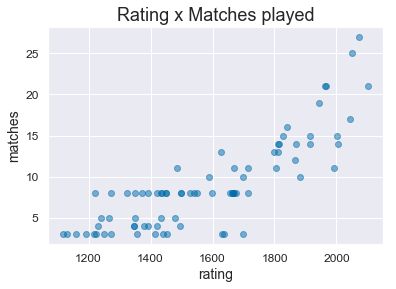

In [20]:
ps.plot_scatter(matches_rating[['rating']], matches_rating[['matches']], 'Rating x Matches played')

The chart above shows us that there's a relationship between the rating and the number of games played. Teams with a greater rating played more games, which makes sense, since the data we gathered is from previous championships, and the teams that managed to keep further in the competitions were the best ones.

<a id='modeling'></a>
## Modeling

<a id="prep"></a>
###  Data Preparation

We have to start recognizing that we have few data points, really few! 354 data points precisely. We are going to try modelling some DS model with really few data points. Because of that, we want to remove some features, the first think is to remove the `home feature` which says if a team is playing at home. 

This data is kind of useless to predict the World Cup results, cause in this case only France is in home. When doing this, one thing is very important to remember: **Guarantee that team I and team J respect lexical order** and features related.

In [21]:
scores = all_matches.drop(columns=['home_a', 'home_b'])
display(scores.head())

,team_a,team_b,score_a,score_b,year,rank_a,rating_a,rank_b,rating_b
0,china,thailand,4,0,2018,16,1866,34,1658
1,china,thailand,3,1,2018,16,1866,34,1658
2,australia,thailand,2,2,2018,6,2003,34,1658
3,united states,thailand,13,0,2019,1,2101,34,1658
4,sweden,thailand,5,1,2019,9,1962,34,1658


In [22]:
def order_teams(df, columns=['team', 'score', 'rank', 'rating']):
    cols_a = [i + '_a' for i in columns] 
    cols_b = [i + '_b' for i in columns] 
    
    df.loc[df['team_b'] < df['team_a'], cols_a + cols_b] = \
        df.loc[df['team_b'] < df['team_a'], cols_b + cols_a].values
    
    return df
    
order_teams(scores)
scores.head()

,team_a,team_b,score_a,score_b,year,rank_a,rating_a,rank_b,rating_b
0,china,thailand,4,0,2018,16,1866,34,1658
1,china,thailand,3,1,2018,16,1866,34,1658
2,australia,thailand,2,2,2018,6,2003,34,1658
3,thailand,united states,0,13,2019,34,1658,1,2101
4,sweden,thailand,5,1,2019,9,1962,34,1658


Now we have to create a target value:

In [23]:
labels = ('win_a', 'draw', 'win_b')

scores['target'] = labels[1]
scores.loc[scores.score_a > scores.score_b, ['target']] = labels[0]
scores.loc[scores.score_a < scores.score_b, ['target']] = labels[2]

scores['target'].value_counts()

win_b    151
win_a    151
draw      52
Name: target, dtype: int64

Then, we have to stop a moment and analysing each feature distribution:

In [24]:
for c in scores.columns:
    print(f'{c} = {scores[c].unique()} \n')

team_a = ['china' 'australia' 'thailand' 'sweden' 'japan' 'brazil' 'argentina'
 'chile' 'netherlands' 'denmark' 'hungary' 'croatia' 'germany' 'canada'
 'faroe islands' 'czech republic' 'france' 'england' 'scotland' 'serbia'
 'finland' 'israel' 'austria' 'jordan' 'philippines' 'nigeria'
 'south korea' 'bosnia and herzegovina' 'albania' 'poland' 'belarus'
 'new zealand' 'cameroon' 'colombia' 'fiji' 'italy' 'belgium' 'bolivia'
 'norway' 'northern ireland' 'ireland' 'algeria' 'ghana' 'mali'
 'equatorial guinea' 'south africa' 'panama' 'trinidad' 'mexico' 'jamaica'
 'cuba' 'costa rica' 'paraguay' 'peru' 'ecuador' 'papua new guinea'
 'new caledonia' 'samoa' 'cook islands' 'kazakhstan' 'russia' 'iceland'
 'portugal' 'moldova'] 

team_b = ['thailand' 'united states' 'japan' 'south korea' 'sweden' 'ukraine'
 'germany' 'south africa' 'russia' 'iceland' 'slovenia' 'zimbabwe' 'spain'
 'philippines' 'jordan' 'china' 'colombia' 'peru' 'chile' 'vietnam'
 'canada' 'jamaica' 'brazil' 'kazakhstan' 'wale

We defined ratings as continuous variable and all others are going to be categorical variables.

In [25]:
X_raw = scores.drop(columns=['target', 'score_a', 'score_b'])
y = scores['target']

display(X_raw.shape)
display(X_raw.sample(3, random_state=13))

display(y.shape)
display(y.sample(3, random_state=13))

(354, 7)

,team_a,team_b,year,rank_a,rating_a,rank_b,rating_b
259,belarus,scotland,2018,55,1436,20,1812
245,poland,switzerland,2018,28,1676,18,1828
99,canada,new zealand,2019,5,2006,19,1815


(354,)

259    win_b
245     draw
99     win_a
Name: target, dtype: object

At this point, we decide to not use the year feature. The year column guides the model to a path of a [time-series problem](https://en.wikipedia.org/wiki/Time_series) and with lack of data we do not want walk to this way.

<a id="preprocess"></a>
### Preprocess Features

We will use [one hot enconding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) to categorical features

In [26]:
# enconding categorical features with one hot encoder
from sklearn.preprocessing import OneHotEncoder

all_countries = np.union1d(X_raw.team_a.unique(), X_raw.team_b.unique())

ohe = OneHotEncoder(categories=[all_countries, all_countries])

feat_cats_raw = ohe.fit_transform(X_raw[['team_a', 'team_b']].astype(str))

feat_cats = pd.DataFrame(feat_cats_raw.todense(), columns=ohe.get_feature_names()).astype(int)
feat_cats.shape

(354, 158)

As a default preprocess data step, we will standardization numerical features. [reference](https://sebastianraschka.com/Articles/2014_about_feature_scaling.html)

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

feat_nums_raw = scaler.fit_transform(X_raw[['rating_a', 'rating_b']])
feat_nums = pd.DataFrame(feat_nums_raw, columns=['rating_a', 'rating_b'])
display(feat_nums.describe())

,rating_a,rating_b
count,3.540000e+02,3.540000e+02
mean,-4.014366e-17,3.813647e-16
std,1.001415e+00,1.001415e+00
min,-2.198113e+00,-2.267244e+00
25%,-8.723496e-01,-8.726298e-01
50%,1.655783e-02,1.752364e-01
75%,9.624465e-01,7.658519e-01
max,1.380309e+00,1.474590e+00


In [28]:
# merging data
X = feat_nums.join(feat_cats)
print(f'shape all merged: {X.shape}')

shape all merged: (354, 160)


##### About Cross Validation

Again at this point, we have to say that we have few data points, because of that we are NOT following the default data split:

`Train | Cross Validation | Test`

We are going to use [kfold](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold) trying to do not throw data away. We will define 4 buckets and then we are going to train each algorithm proposed 4 times, using k-1 bucket, and evaluate metric with the one that remains. In conclusion, we will have 4 metrics for each model, the final metric for each model is the average of those metrics. After that, we are going to compare each model proposed to choose the best one.

We will use Stratified Kfold to guarantee that classes are equally devided among the folds.

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=43)
kf.get_n_splits(X, y)
k_fold_indexes = [(train, test) for train, test in kf.split(X, y)]

def train_model_k_fold(model, score, train_data=X, target_data=y):
    scores = []
    confusion_matrixes = []
    
    for train, test in k_fold_indexes:       
        X_train, X_test, y_train, y_test = \
            train_data.iloc[train], train_data.iloc[test], target_data.iloc[train], target_data.iloc[test]

        model.fit(X_train, y_train)
        scores.append(score(model, X_test, y_test))
        
    return np.mean(scores)

<a id="model_selection"></a>
## The Model - First Scene - Compare some algorithms

### Choosing a score

Now, we have to choose a good metric to our model optimizing. We found in [fbeta score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) a good metric to our propose, more specific with a `Beta=2`, which gave to the model model an approach based on recall. This is good because we want to find each of the True Positives (for each class). Explaining more about this, we will calculate the True Positives for each class, and then we will calculate an weighted average base on the ocurrency of each class.

As we know, there is some unbalance between the 3 target class - draw, win_a and win_b - and probably `draw` results will be sacrificed to we find better `win_a` and `win_b`. We are ok with that.

In [30]:
from sklearn.metrics import fbeta_score

from sklearn.metrics import make_scorer

score = make_scorer(fbeta_score, beta=2, labels=labels, average='weighted')

### Comparing models

Now, we want to compare models with our data and see how they fit with it. The propose at this stage is to define the simplest model (without hyperparameter tunning) for the algorithm that we are considering. So, we will make some analysis trying to find if the model has high variance, high bias, how it fits the data, etc.

We will plot [learning curves](https://www.ritchieng.com/machinelearning-learning-curve/) to make those analysis.

Decision Tree: 0.591567893585591
Logistic Regression: 0.6849284474408703
SVC kernel=linear: 0.6733698293465948
SVC kernel=poly: 0.5020222452144263
SVC kernel=rbf: 0.6822850581727442
SVC kernel=sigmoid: 0.6794147519757172
Random Forest: 0.6340373653885581
Gradient Boosting: 0.6406310220314752


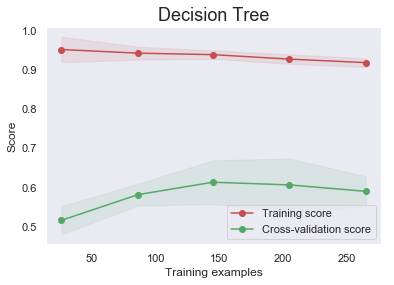

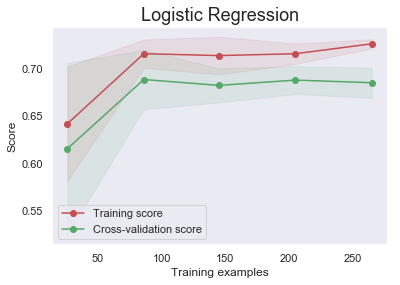

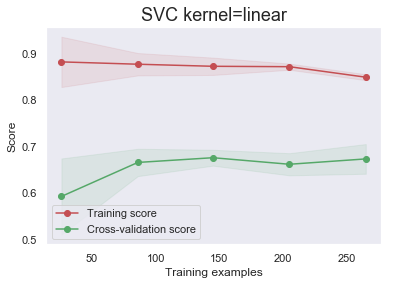

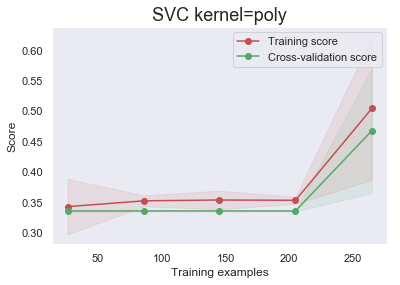

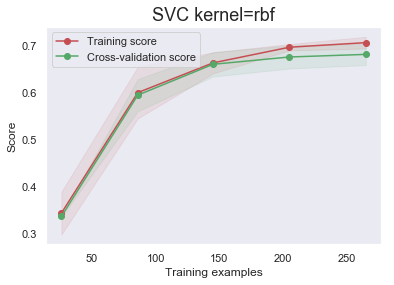

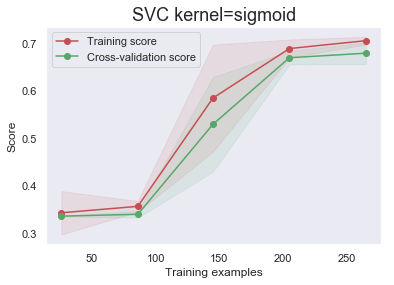

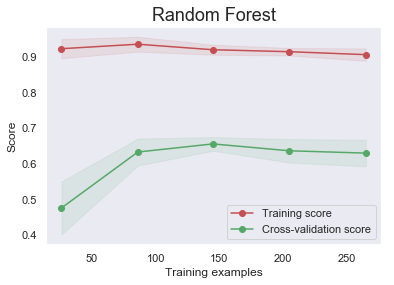

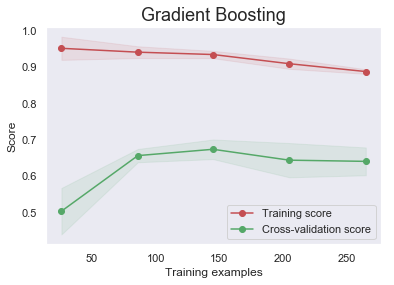

In [31]:
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = []

models.append(("Decision Tree", DecisionTreeClassifier(random_state=4)))
models.append(("Logistic Regression", LogisticRegression(solver='lbfgs', C=0.1, multi_class='auto', random_state=4)))
models.append(("SVC kernel=linear", SVC(kernel='linear', random_state=4)))
models.append(("SVC kernel=poly", SVC(kernel='poly', gamma='auto', random_state=23)))
models.append(("SVC kernel=rbf", SVC(kernel='rbf', gamma='auto', random_state=4)))
models.append(("SVC kernel=sigmoid", SVC(kernel='sigmoid', gamma='auto', random_state=4)))
models.append(("Random Forest", RandomForestClassifier(n_estimators=10, random_state=4)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=4)))


for name, model in models:
    print(f'{name}: {train_model_k_fold(model, score)}')
    ps.plot_learning_curve(model, name, X, y, cv=k_fold_indexes, scoring=score)


### Model Analysis

#### Decision Tree
`f2-score = 0.59`

Learning Curve show us that the model extremelly overfits the data, the gap between the curves shows this, so the model has high variance and acquiring more data could help this overfits behavior. But, decision trees tend to overfit a lot, even more when we don't do feature selection, like we didn't.

#### Logistic Regression
`f2-score = 0.69`

Learning Curve shows a very nice pattern: high score with some close curves. We made a simple hyper parameter tunning at this stage (cheating, ok!) tunning C to regularize our 150+ features =D. Model answered very nice for our propose, one of the best choices.

#### SVC
`kernel: linear -> f2-score = 0.67`

`kernel: poly -> f2-score = 0.50`

`kernel: rbf -> f2-score = 0.68`

`kernel: sigmoid -> f2-score = 0.68`

At this point we made a simple hyper parameter tunning again (cheating). It doesn't make sense to choose an SVM model without chosen a kernel, so we create 4 svc models, one for each basic kernel that has in sklearn.

Linear kernel has high variance (overfit the data),and poly kernel has high bias (underfit the data). Sigmoid and rbf are both nice!

#### Ensemble Methods
`Gradient Boosting -> f2-score = 0.64`

`Random Forest -> f2-score = 0.63`

Both have good metrics, but is easy to see in learning curves that both are overfitted. In both cases, we think that more data could fix this overfitting problem, sadly we don't have more data, so let's move on.

### Final Comments

There are a bunch of other models that we could explore, but at this point, for our propose, those are enough to find a good solution.

We decided to stress Linear Regression and SVC with sigmoid and rbf kernel to the next stages.

<a id="best_model"></a>

## The Model - Second Scene - Stressing some algorithms

At this part we will find the best hyper parameters to the chosen models. We will use the simplest way to find the best hyper parameters a [grid search](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)

In [32]:
from sklearn.model_selection import GridSearchCV

### Linear Regression

In [33]:
parameters_lr = {'solver': ('newton-cg', 'sag', 'saga', 'lbfgs'),
                 'C': np.unique(np.geomspace(0.001, 1, num=15, dtype=float)),
                 'max_iter': np.unique(np.geomspace(50, 200, num=3, dtype=int)),
                 'class_weight': (None,
                                  'balanced',
                                  {'win_a': (354/(354-151)), 'win_b': (354/(354-151)), 'draw': (354/(354-52))},
                                  {'win_a': (354/(354-151)), 'win_b': (354/(354-151)), 'draw': (354/(354-(2*52)))})}

lr = LogisticRegression(multi_class='auto')

gd_model_lr = GridSearchCV(lr,
                           parameters_lr,
                           n_jobs=8,
                           cv=k_fold_indexes,
                           iid=True,
                           scoring=score,
                           verbose=1)
gd_model_lr.fit(X, y)

display(gd_model_lr.best_estimator_)
gd_model_lr.best_score_


Fitting 4 folds for each of 720 candidates, totalling 2880 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 124 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1024 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 2524 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done 2880 out of 2880 | elapsed:    9.5s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=49,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

0.6962494535605067

### SVC

In [34]:
parameters_scv = {'kernel': ('sigmoid', 'rbf'),
                  'C': np.unique(np.geomspace(0.01, 1000, num=10, dtype=float)),
                  'coef0': np.unique(np.geomspace(0.01, 10, num=5, dtype=float)),
                  'class_weight': (None,
                                   'balanced',
                                   {'win_a': (354/(354-151)), 'win_b': (354/(354-151)), 'draw': (354/(354-52))},
                                   {'win_a': (354/(354-151)), 'win_b': (354/(354-151)), 'draw': (354/(354-(2*52)))}),
                  'gamma': list(np.unique(np.geomspace(0.0001, 10, num=7, dtype=float))) + ['scale', 'auto'],
                  'tol': np.unique(np.geomspace(0.0001, 10, num=6, dtype=float))}


svc = SVC(decision_function_shape='ovo', random_state=37)

gd_model_svc = GridSearchCV(svc,
                            parameters_scv,
                            n_jobs=8,
                            cv=k_fold_indexes,
                            iid=True,
                            scoring=score,
                            verbose=1)
gd_model_svc.fit(X, y)


display(gd_model_svc.best_estimator_)
gd_model_svc.best_score_

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 21600 candidates, totalling 86400 fits


[Parallel(n_jobs=8)]: Done 232 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 5032 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Done 9232 tasks      | elapsed:   27.4s
[Parallel(n_jobs=8)]: Done 14632 tasks      | elapsed:   43.5s
[Parallel(n_jobs=8)]: Done 21232 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 29032 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 38032 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 48232 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 59632 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 72232 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 86032 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 86400 out of 86400 | elapsed:  3.8min finished


SVC(C=0.03593813663804628, cache_size=200, class_weight=None, coef0=0.01,
    decision_function_shape='ovo', degree=3, gamma=1.4677992676220706,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=37,
    shrinking=True, tol=0.1, verbose=False)

0.7113839596643519

## The Model - Last Scene - The Final One

The final Model is:


SVC(C=0.03593813663804628, cache_size=200, class_weight=None, coef0=0.01,
    decision_function_shape='ovo', degree=3, gamma=1.4677992676220706,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=37,
    shrinking=True, tol=0.1, verbose=False)

The fbeta score of it is 0.7113176991075336


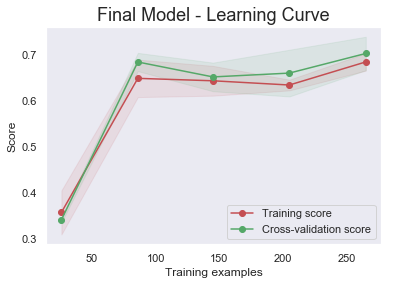

In [35]:
best_model = gd_model_svc.best_estimator_

print('The final Model is:')
display(best_model)

print(f'The fbeta score of it is {train_model_k_fold(best_model, score)}')

ps.plot_learning_curve(best_model, 'Final Model - Learning Curve', X, y, cv=k_fold_indexes, scoring=score);

### Confusion Matrix

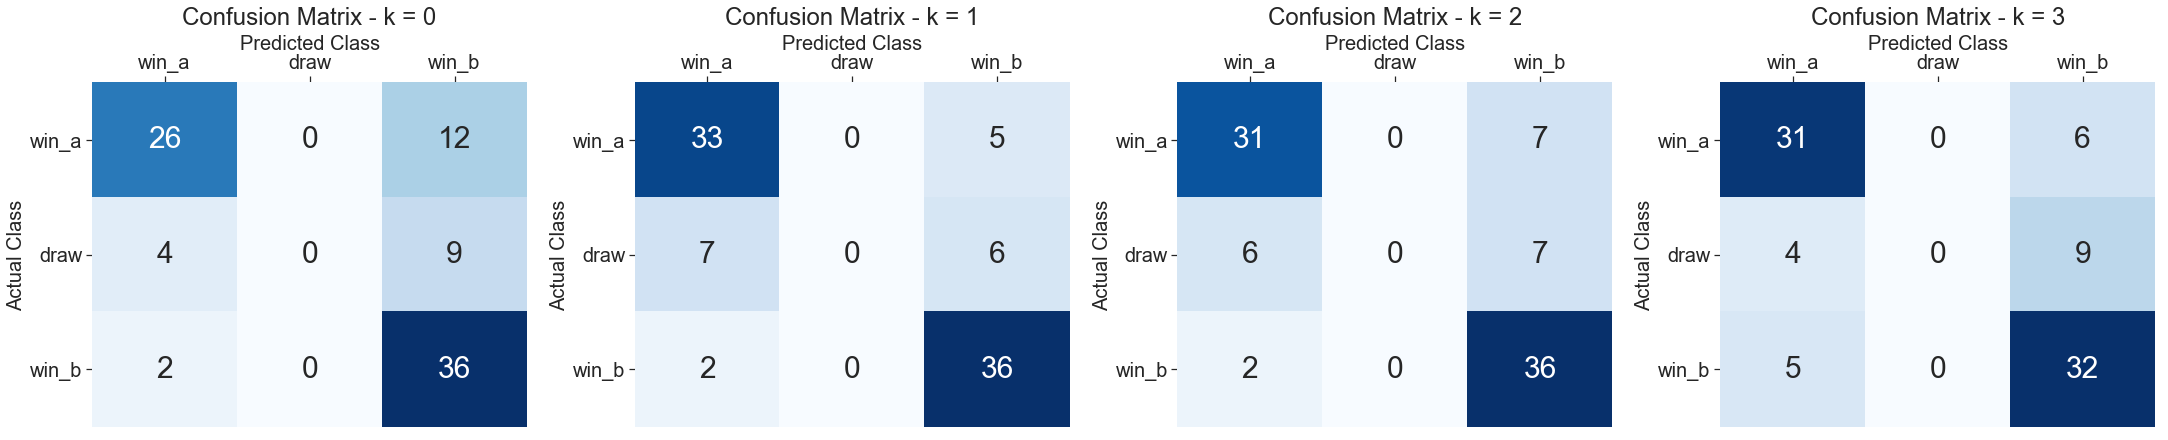

In [36]:
confusion_matrixes = []
    
for train, test in k_fold_indexes:       
    X_train, X_test, y_train, y_test = \
        X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

    best_model.fit(X_train, y_train)
    cm = confusion_matrix(y_test, best_model.predict(X_test), labels=labels)
    confusion_matrixes.append(cm)
    
ps.print_confusion_matrixes(confusion_matrixes, labels)

### Final Conclusions

We do not have a test data to make a last evaluation of the model, because, like we said, we went to a k-fold approach. At this point, we just want to see the confusion matrix of "the best model". However, to see this we have to plot each confusion matrix for each model created in k-fold function that we designed. The plots are above.

We could see that the weakness of our model is the power of predict draws. The recall and precision of each win class (win_a and win_b) are good and we are happy with that. A little parenthesis in here: the precision of first model represented by the k=0 confusion matrix, has a little low precision of win_b. This behavior is particulary lower than we expected, but we are ok and decide to move on. 

In fact, we are going to use the model to predict knockout phase, so a model that does not predict a draw is very useful at this point.

Overall we are satisfied with the model and the results.

<a id="final"></a>
## Predict the rest of the Female World Cup

To predict we will retrain **the best model** with all data

In [37]:
final_model = best_model.fit(X, y)

And then create some helpful functions to make predictions

In [38]:
def preprocess(df_raw):    
    df = (df_raw.merge(ranking, left_on='team_a', right_on='team')
                .rename(columns={'rating': 'rating_a',
                                 'rank': 'rank_a'})
                .drop(columns=['team'])
                .merge(ranking, left_on='team_b', right_on='team')
                .rename(columns={'rating': 'rating_b',
                                 'rank': 'rank_b'})
                .drop(columns=['team']))
    
    df = order_teams(df, columns=['team', 'rank', 'rating'])
    
    feat_nums_raw = scaler.transform(df[['rating_a', 'rating_b']])
    feat_nums = pd.DataFrame(feat_nums_raw, columns=['rating_a', 'rating_b'])

    feat_cats_raw = ohe.transform(df[['team_a', 'team_b']].astype(str))
    feat_cats = pd.DataFrame(feat_cats_raw.todense(), columns=ohe.get_feature_names()).astype(int)
    
    return feat_nums.join(feat_cats), df

def display_results(round_list):
    r = {'team_a': [a for a, _ in round_list],
         'team_b': [b for _, b in round_list],}

    df = pd.DataFrame.from_dict(r)
    
    preprocessed, preds = preprocess(df)
    preds['prediction'] = final_model.predict(preprocessed)
    preds['winner'] = preds.team_a
    preds.loc[preds['prediction'] == 'win_b', ['winner']] = preds.loc[preds['prediction'] == 'win_b', ['team_b']].values
    display(preds)

### Finally - The Predictions

In [39]:
round_16 = [('norway', 'australia'),
            ('england', 'cameroon'),
            ('france', 'brazil'),
            ('spain', 'united states'),
            ('italy', 'china'),
            ('netherlands', 'japan'),
            ('germany', 'nigeria'),
            ('sweden', 'canada'),] 

display_results(round_16)

,team_a,team_b,rank_a,rating_a,rank_b,rating_b,prediction,winner
0,australia,norway,6,2003,12,1915,win_a,australia
1,cameroon,england,46,1499,3,2049,win_b,england
2,brazil,france,10,1944,4,2043,win_b,france
3,spain,united states,13,1913,1,2101,win_b,united states
4,china,italy,16,1866,15,1868,win_a,china
5,japan,netherlands,7,1991,8,1967,win_b,netherlands
6,germany,nigeria,2,2072,38,1599,win_a,germany
7,canada,sweden,5,2006,9,1962,win_b,sweden


In [40]:
round_8 = [('australia', 'england'),
           ('france', 'united states'),
           ('china', 'netherlands'),
           ('germany', 'sweden')] 

display_results(round_8)

,team_a,team_b,rank_a,rating_a,rank_b,rating_b,prediction,winner
0,australia,england,6.0,2003.0,3.0,2049.0,win_b,england
1,france,united states,4.0,2043.0,1.0,2101.0,win_b,united states
2,china,netherlands,16.0,1866.0,8.0,1967.0,win_b,netherlands
3,germany,sweden,2.0,2072.0,9.0,1962.0,win_b,sweden


In [41]:
round_4 = [('england', 'united states'),
           ('netherlands', 'sweden'),] 

display_results(round_4)

,team_a,team_b,rank_a,rating_a,rank_b,rating_b,prediction,winner
0,england,united states,3.0,2049.0,1.0,2101.0,win_b,united states
1,netherlands,sweden,8.0,1967.0,9.0,1962.0,win_b,sweden


In [42]:
final = [('united states', 'sweden'),] 

display_results(final)

,team_a,team_b,rank_a,rating_a,rank_b,rating_b,prediction,winner
0,sweden,united states,9,1962,1,2101,win_b,united states


In [43]:
third_place = [('england', 'netherlands'),] 

display_results(third_place)

,team_a,team_b,rank_a,rating_a,rank_b,rating_b,prediction,winner
0,england,netherlands,3.0,2049.0,8.0,1967.0,win_b,netherlands


### How about France?

In our analysis we saw that playing in home increases the chance of winning. However, our model predicted France being eliminated by United States at quarter finals. For curiosity we simulated a cenario that France wins the game agains United States. See how curious is that:

In [44]:
round_4 = [('england', 'france'),
           ('netherlands', 'sweden'),] 

display_results(round_4)

,team_a,team_b,rank_a,rating_a,rank_b,rating_b,prediction,winner
0,england,france,3.0,2049.0,4.0,2043.0,win_b,france
1,netherlands,sweden,8.0,1967.0,9.0,1962.0,win_b,sweden


In [45]:
final = [('france', 'sweden'),] 

display_results(final)

,team_a,team_b,rank_a,rating_a,rank_b,rating_b,prediction,winner
0,france,sweden,4.0,2043.0,9.0,1962.0,win_b,sweden


We particulary loved this cenario! According to our model: if France wins United States on quarter finals, the big underdogs Sweden wins the World Cup against France in the final!!!!

We are cheering for Sweden!